In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.utils import shuffle
from utils import PLSRComponents
from brokenaxes import brokenaxes

In [2]:
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'

In [3]:
from curvefit import DatasetSpectra

2024-10-27 16:18:42.277762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 16:18:42.290281: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 16:18:42.293788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from boxsers.preprocessing import rubberband_baseline_cor

In [5]:
file_path = '~/data/dataset_681.csv'
domain_path = '~/data/dataset_565_domain.csv'

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fb80eb7ebc0>>
Traceback (most recent call last):
  File "/home/mykola/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


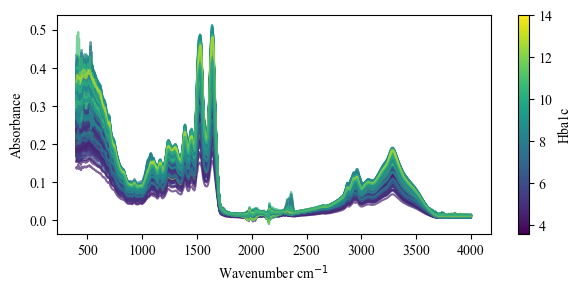

In [6]:
dataset = DatasetSpectra(file_path, domain_path)
dataset.select_max_hba1c(14)
dataset.select_region([400, 4000])
dataset.drop_samples([287, 636])
fig1, ax1 = dataset.plot_spectra()
plt.subplots_adjust(bottom=0.15)
plt.savefig('figures/spectra_before_preproc.pdf', format='pdf', transparent=True)

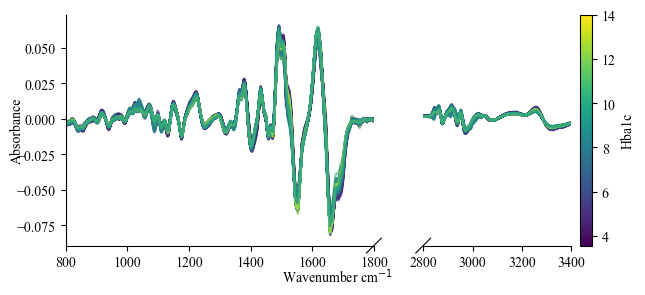

In [29]:
# dataset.baseline_corr()
dataset.savgol_filter(window_length=32, polyorder=2, deriv=1)
dataset.normalization('vector')
dataset.select_region([[800, 1800], [2800, 3400]])
# dataset.select_region([800, 1800])
fig2, ax2 = dataset.plot_spectra()
plt.savefig('figures/spectra_after_preproc.pdf', format='pdf', transparent=True)

In [30]:
dataset.n_samples

673

In [31]:
X = dataset.spectra
y = dataset.hba1c

In [32]:
X.shape

(673, 3319)

<5.7%       250
5.7-6.5%     78
>6.5%       345
Name: count, dtype: int64


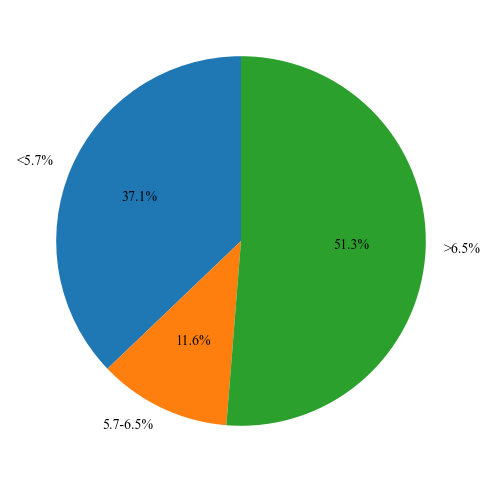

In [33]:
bins = [0, 5.7, 6.5, 14]
labels = ['<5.7%', '5.7-6.5%', '>6.5%']

binned_data = pd.cut(y, bins=bins, labels=labels, include_lowest=True)
bin_counts = binned_data.value_counts()

plt.figure(figsize=(6, 6))
plt.pie(bin_counts, labels=bin_counts.index, autopct='%1.1f%%', startangle=90)
print(bin_counts)

In [34]:
y.min()

3.57

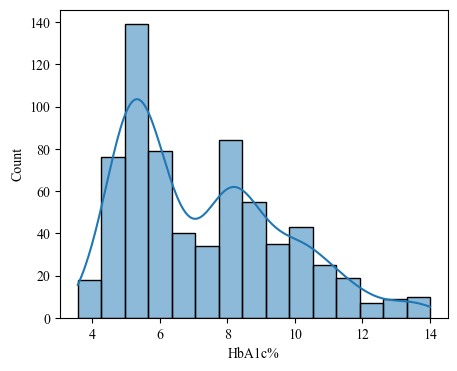

In [35]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.histplot(y, kde=True, bins=15)
ax.set_xlabel("HbA1c%")
fig.savefig('figures/hba1c_dist.pdf', format='pdf', transparent=True)

In [36]:
discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform', subsample=None, random_state=4)
categories = discretizer.fit_transform(y.reshape(-1, 1))

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=categories, random_state=34)

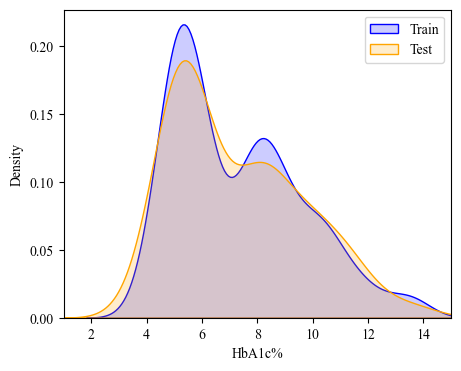

In [38]:
fig, ax = plt.subplots(figsize=(5, 4))

sns.kdeplot(y_train, ax=ax, color='blue', fill=True, alpha=0.2, label='Train')
sns.kdeplot(y_test, ax=ax, color='orange', fill=True, alpha=0.2, label='Test')

ax.set_xlabel('HbA1c%')
ax.set_xlim([1, 15])
ax.legend()

fig.savefig('figures/train_test.pdf', format='pdf', transparent=True)

In [46]:
X_train, y_train = shuffle(X_train, y_train, random_state=20) # 15

(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: xlabel='Number of components', ylabel='R²'>,
         <Axes: xlabel='Number of components', ylabel='RMSECV'>],
        [<Axes: xlabel='HbA1c% measured', ylabel='HbA1c% predicted'>,
         <Axes: xlabel='HbA1c%', ylabel='Residuals'>]], dtype=object))

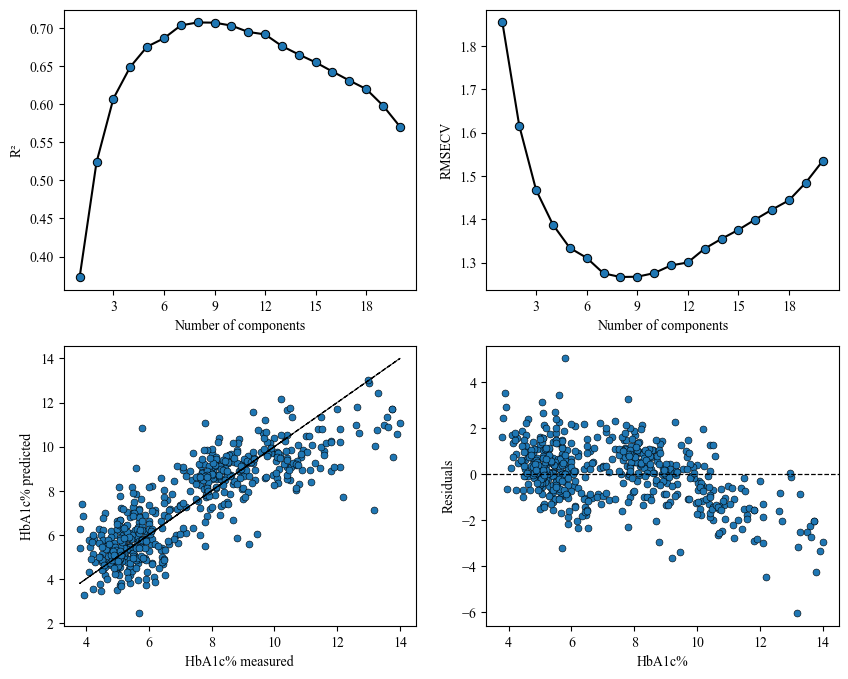

In [47]:
model = PLSRComponents()
model.fit(X_train, y_train, ncomp=20, cv=10, threshold=0)
model.plot_number_components()

# plt.savefig('figures/crossval_plsr.png', dpi=200, transparent=True)
# plt.savefig('figures/crossval_plsr.pdf', format='pdf', transparent=True)

(<Figure size 700x400 with 1 Axes>,
 <Axes: xlabel='HbA1c% measured', ylabel='HbA1c% predicted'>)

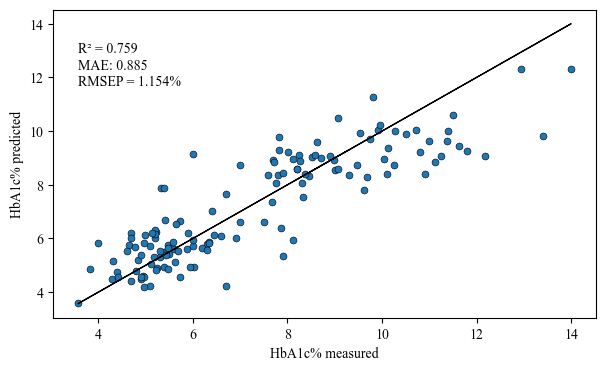

In [48]:
model.evaluate(X_test, y_test)
# fig.savefig('figures/validation_plsr.pdf', format='pdf', transparent=True)

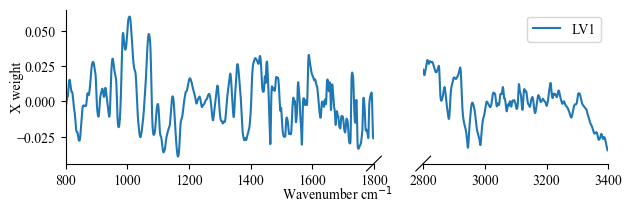

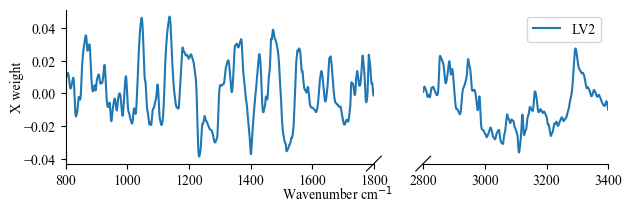

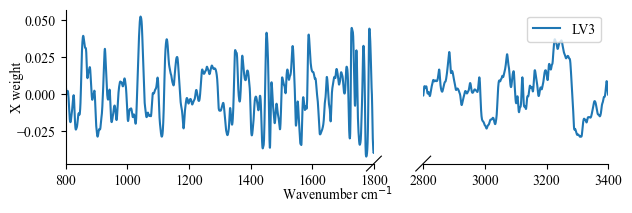

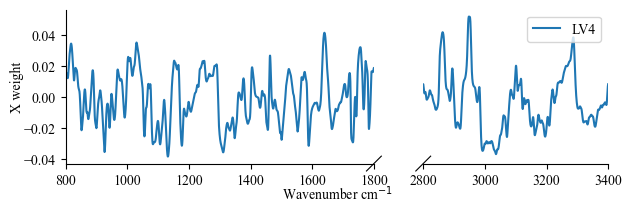

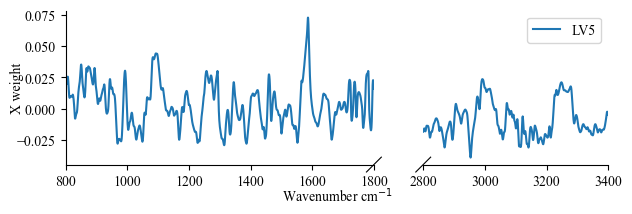

In [42]:
pls = model.get_fitted_model()

for i in range(1, 6):
    fig = plt.figure(figsize=(7, 2))
    bax = brokenaxes(xlims=((800, 1800), (2800, 3400)), hspace=0.1)
    bax.plot(dataset.wavenumbers, pls.x_weights_[:, i], label=f'LV{i}')
    bax.set_xlabel("Wavenumber cm$^{-1}$")
    bax.set_ylabel("X weight")
    bax.legend()
    # plt.subplots_adjust(bottom=0.10)
    plt.show()
    fig.savefig(f'figures/lv_plsr_{i}.png', transparent=True, dpi=300)

Text(0, 0.5, 'Normalized weight')

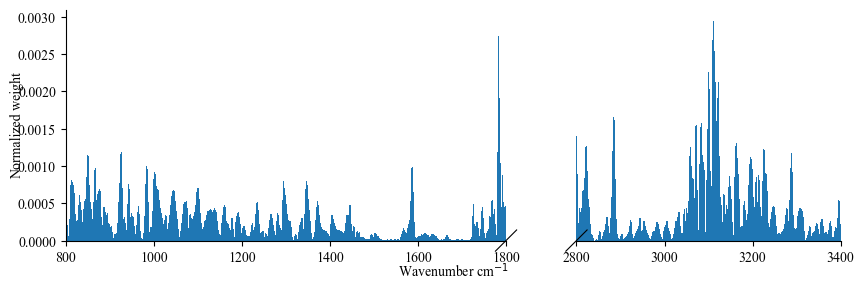

In [43]:
normalized_weight = np.abs(pls.coef_.reshape(-1)) / np.sum(np.abs(pls.coef_.reshape(-1)))

fig = plt.figure(figsize=(10, 3))
bax = brokenaxes(xlims=((800, 1800), (2800, 3400)), hspace=0.001)

bax.bar(dataset.wavenumbers, normalized_weight, width=2, label='LV1')

bax.set_xlabel("Wavenumber cm$^{-1}$")
bax.set_ylabel("Normalized weight")

In [44]:
def explained_variance(model, y_train):
    r2_sum = 0
    for comp in range(0, model.n_components):
        y_pred = np.dot(model.x_scores_[:, comp].reshape(-1, 1), model.y_loadings_[:, comp].reshape(-1, 1).T) + y_train.mean(axis=0)
        r2_sum += round(r2_score(y_train, y_pred), 3)
        print('R2 for %d component: %g' %(comp + 1,round(r2_score(y_train, y_pred), 3)))
        print(f'R2 for all {comp + 1} components: {r2_sum}')
    
explained_variance(pls, y_train)

R2 for 1 component: 0.257
R2 for all 1 components: 0.257
R2 for 2 component: 0.111
R2 for all 2 components: 0.368
R2 for 3 component: 0.061
R2 for all 3 components: 0.429
R2 for 4 component: 0.032
R2 for all 4 components: 0.46099999999999997
R2 for 5 component: 0.022
R2 for all 5 components: 0.483
R2 for 6 component: 0.01
R2 for all 6 components: 0.493
R2 for 7 component: 0.02
R2 for all 7 components: 0.513
R2 for 8 component: 0.011
R2 for all 8 components: 0.524
R2 for 9 component: 0.004
R2 for all 9 components: 0.528
